In [1]:
import sys

from forcefield import CGForceField
from model_builder import CGModelBuilder
from openmm import LangevinMiddleIntegrator, MonteCarloBarostat, unit
from openmm.app import PDBFile, Simulation, StateDataReporter, XTCReporter


In [7]:
builder = CGModelBuilder(
    smiles_sequence="[EO]100",
    bond_length=0.36,  # nm
    min_dist=0.41,  # nm
    max_tries=50000,
)
topology, positions = builder.create_molecule()

with open("peo100.pdb", "w") as f:
    PDBFile.writeFile(topology, positions, f)

structures = [
    {
        "pdb": "peo100.pdb",
        "number": 100,
        "box": (0, 0, 0, 25, 25, 25),
    },
]
topology, positions = builder.create_packed_model(
    structures,
    box_size=(25, 25, 25),  # nm
    output_pdb="peo100_100.pdb",
)

In [8]:
param_dict = {
    "BOND": {
        ("EO", "EO"): {"r0": 0.36, "k": 7000},
    },
    "ANGLE": {
        ("EO", "EO", "EO"): {"theta0": 2.147, "k": 80},
    },
    "TORSION": {
        ("EO", "EO", "EO", "EO"): [
            {"periodicity": 1, "phase": 0.0, "k": -1.328},
            {"periodicity": 2, "phase": 0.0, "k": -0.437},
            {"periodicity": 3, "phase": 0.0, "k": 1.081},
            {"periodicity": 4, "phase": 0.0, "k": 0.680},
        ]
    },
    "NONBONDED": {
        "EO": {"sigma": 0.41, "epsilon": 2.35, "charge": 0.0, "mass": 44.0},
    },
}
ff = CGForceField.from_dict(param_dict)
system = ff.create_system(topology)

In [12]:
!rm md_traj.xtc md.log
temperature = 300 * unit.kelvin
friction = 10 / unit.picosecond
timestep = 20 * unit.femtosecond
integrator = LangevinMiddleIntegrator(temperature, friction, timestep)
simulation = Simulation(topology, system, integrator)

barostat = MonteCarloBarostat(1.0 * unit.atmospheres, temperature)
simulation.system.addForce(barostat)

simulation.context.setPositions(positions)

simulation.reporters.append(XTCReporter("md_traj.xtc", 1000))
simulation.reporters.append(
    StateDataReporter(
        sys.stdout,
        1000,
        step=True,
        time=True,
        potentialEnergy=True,
        kineticEnergy=True,
        temperature=True,
        volume=True,
        density=True,
    )
)
simulation.reporters.append(
    StateDataReporter(
        "md.log",
        1000,
        step=True,
        time=True,
        potentialEnergy=True,
        kineticEnergy=True,
        temperature=True,
        volume=True,
        density=True,
    )
)

state = simulation.context.getState(
    getPositions=True, getEnergy=True, enforcePeriodicBox=True
)
PDBFile.writeFile(
    simulation.topology, state.getPositions(), open("md_traj_init.pdb", "w")
)
simulation.context.reinitialize(preserveState=True)
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(300 * unit.kelvin)
simulation.step(1_000_000)

#"Step","Time (ps)","Potential Energy (kJ/mole)","Kinetic Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)","Density (g/mL)"
1000,19.999999999999662,-89343.42238204085,36618.054922567906,293.60931350807533,16341.107526742546,0.04471160772675844
2000,40.000000000000654,-92777.65619681973,36972.14675180792,296.44847738834756,15997.695285362886,0.045671403069227734
3000,60.00000000000378,-94563.63658684668,37362.59738762004,299.5791718881511,15601.482546256448,0.046831266669064585
4000,80.00000000000122,-96970.65065065185,37210.39783236825,298.35881195837857,15252.759823728948,0.04790196646378901
5000,99.99999999999724,-96709.07042895729,36879.51218281715,295.70571887028836,14955.374731072807,0.04885448895094861
6000,119.99999999999326,-97153.91336334027,37496.67824128749,300.65425322393264,14658.611241517043,0.049843547763047
7000,139.9999999999978,-97686.09383434648,37655.83517090154,301.9303984736694,14495.59017180954,0.050404100895278296
8000,160.00000000000804,-98533.7164345594

In [11]:
import MDAnalysis as mda
import nglview as nv

bonds = list(topology.bonds())
bonds_nglview = []
for bond in bonds:
    bonds_nglview.append((bond[0].index, bond[1].index))
u = mda.Universe("md_traj_init.pdb", "md_traj.xtc")
u.add_TopologyAttr("bonds", bonds_nglview)
view = nv.show_mdanalysis(u)
view.add_ball_and_stick()
view.add_representation("ball+stick", colorScheme="resname")
view.add_representation("unitcell")
view

/home/mori/work/flowapp/.venv/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:295: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "
/home/mori/work/flowapp/.venv/lib/python3.12/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(max_frame=99)

In [14]:
import pandas as pd

df = pd.read_csv("md.log")

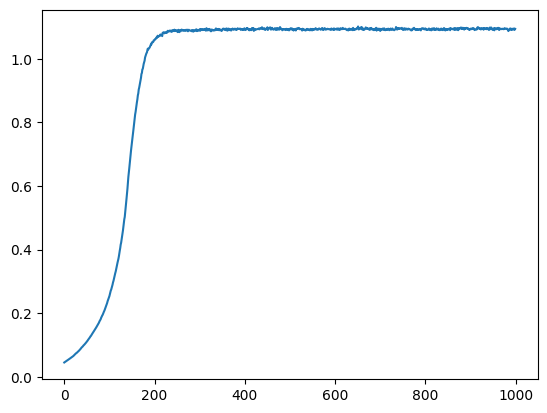

In [15]:
import matplotlib.pyplot as plt

plt.plot(df["Density (g/mL)"])

: 

: 